In [1]:
!python --version # should say 3.7.16

Python 3.7.16


In [1]:
import os
from agent import Agent, recursive_obs_dict_to_spaces_dict
from action_net import ActionNet
os.chdir("..")
from rice import Rice

import torch
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import List

/home/ivaylo/.local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = Rice(negotiation_on = False)

In [3]:
initial_state = env.reset()

In [4]:
def create_agents() -> List[Agent]:
    agents = []
    for agent_id in initial_state:
        agents.append(
            Agent(
                #observation_space = get_observation_space(agent_id),
                #action_space = get_action_space(agent_id),
                observation_space = recursive_obs_dict_to_spaces_dict(initial_state[agent_id]),
                action_space = env.action_space[agent_id],
                id = agent_id
            )
        )
    return agents

In [5]:
agents = create_agents()

In [6]:
agents = create_agents()
collective_action = {}
for agent in agents:
    action, log_prob = agent.act(0, initial_state[0])#trim_observation(initial_state, agent.id))
    #print(action)
    #print(log_prob)
    #saved_log_probs[agent.id].append(log_prob)
    collective_action[agent.id] = np.array(action)

state, reward, done, _ = env.step(collective_action)

In [7]:
env = Rice()

In [8]:
# Adapted from https://huggingface.co/deep-rl-course/unit4/hands-on?fw=pt
def reinforce(agents : List[Agent], 
              n_training_episodes : int, 
              gamma : float) -> None:
    
    optimizers = [torch.optim.Adam(agent.nets[0].parameters(), lr=.01) for agent in agents]
    
    losses = [[] for agent in agents]
    all_returns = [[] for agent in agents]
    
    for i_episode in tqdm(range(1, n_training_episodes+1)):
        saved_log_probs = [[] for agent in agents]
        rewards = [[] for agent in agents]
        state = env.reset()
        assert env.timestep == 0
        
        # Generate a whole episode
        for t in range(env.episode_length):
            collective_action = {}
            for agent in agents:
                action, log_prob = agent.act(0, state[agent.id])
                saved_log_probs[agent.id].append(log_prob)
                collective_action[agent.id] = np.array(action)
                
            state, reward, done, _ = env.step(collective_action)
            
            for agent in agents:
                rewards[agent.id].append(reward[agent.id])
        
        returns = [deque(maxlen=env.episode_length) for agent in agents] 
        
        # Calculate discounted returns
        for t in range(env.episode_length)[::-1]:
            for agent in agents:
                disc_return_t = (returns[agent.id][0] if len(returns[agent.id])>0 else 0)
                returns[agent.id].appendleft( gamma*disc_return_t + rewards[agent.id][t]   )    
            
        eps = np.finfo(np.float32).eps.item()
        
        # Standardize returns
        returns = [torch.tensor(returns[agent.id]) for agent in agents]
        for agent in agents:
            all_returns[agent.id].append(returns[agent.id].mean().item())
            returns[agent.id] = (returns[agent.id] - returns[agent.id].mean()) / (returns[agent.id].std() + eps)

        # Calculate loss and update weights
        policy_loss = [[] for agent in agents]
        for agent in agents:
            for log_prob, disc_return in zip(saved_log_probs[agent.id], returns[agent.id]):
                policy_loss[agent.id].append(-log_prob * disc_return)
            loss = torch.cat(policy_loss[agent.id]).sum()
            losses[agent.id].append(loss.item())
            
            optimizers[agent.id].zero_grad()
            loss.backward()
            optimizers[agent.id].step()
    return losses, all_returns

In [9]:
losses, returns = reinforce(agents, n_training_episodes = 100, gamma = .9)

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


In [10]:
returns

[[0.2557363478182359,
  0.22858708778462083,
  0.28512707662975634,
  0.3214123916875592,
  0.28962575126006757,
  0.2655523469561133,
  0.32632549786801684,
  0.2625350054150593,
  0.30820454501570016,
  0.2789551046117263,
  0.3303986677694336,
  0.3714260892929063,
  0.34872619974940433,
  0.3604663891989636,
  0.28371992238374294,
  0.29939624912156876,
  0.33251715241843216,
  0.37552869092985997,
  0.3819601314668881,
  0.35082530324105854,
  0.37944691537423375,
  0.378960393793199,
  0.3779813244943295,
  0.37871965154166176,
  0.35170272372262107,
  0.37508645440371186,
  0.3731298547531529,
  0.3357275930702731,
  0.3640980194288238,
  0.3601766834406403,
  0.3461318625771876,
  0.3401630052705443,
  0.28132737589006745,
  0.3620140245868106,
  0.34508130965811745,
  0.3412446356293513,
  0.36220300052454396,
  0.377122977683866,
  0.37966930512337826,
  0.3523324810135521,
  0.36732275831467237,
  0.3652430073084169,
  0.3725960664697358,
  0.32032978683681995,
  0.347347528

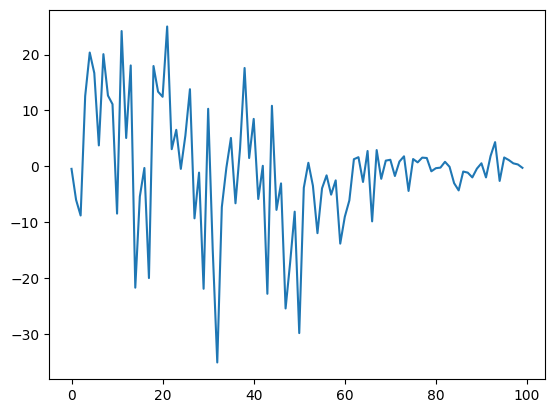

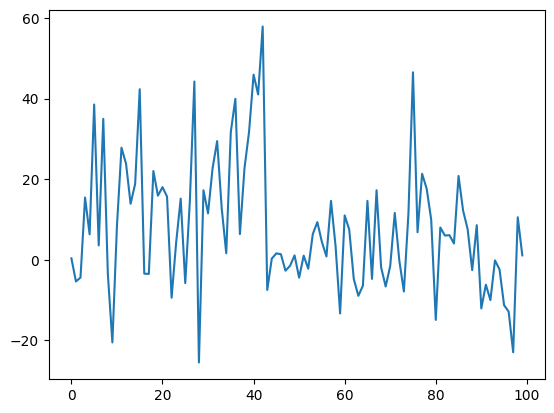

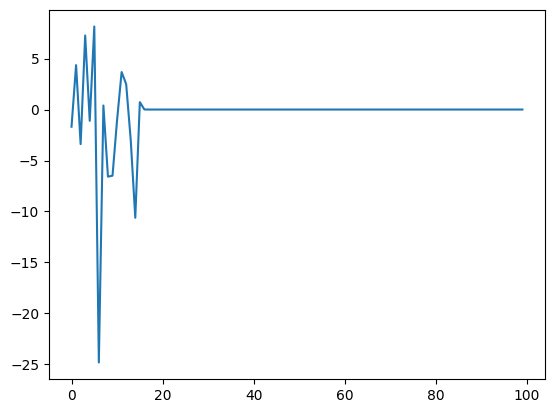

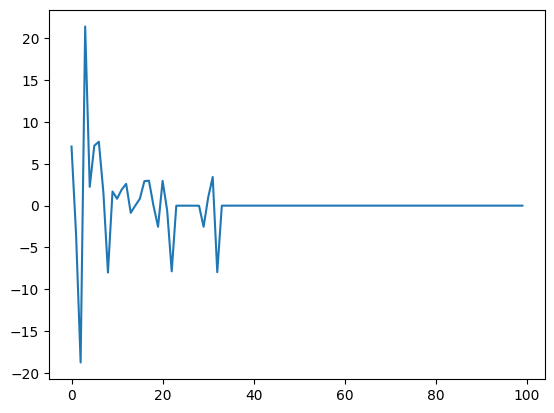

In [11]:
for agent in agents:
    plt.plot(losses[agent.id])
    plt.show()

In [12]:
def evaluate_agents(agents : List[Agent]) -> dict:
    state = env.reset()
    collective_actions = []
    all_rewards = [[] for agent in agents]
    for i in range(env.episode_length):
        collective_action = {}
        for agent in agents:
            action, _ = agent.act(0, state[agent.id])
            collective_action[agent.id] = np.array(action)
        state, reward, done, _ = env.step(collective_action)
        
        for agent in agents:
            all_rewards[agent.id].append(reward[agent.id])
        
        collective_actions.append(collective_action)
    return env.global_state, collective_actions, all_rewards

In [13]:
def baseline() -> dict:
    return evaluate_agents(create_agents())

In [14]:
state, actions, rewards = evaluate_agents(agents)

In [15]:
state_base, actions_base, rewards_base = baseline()

In [23]:
[list(zip(l1, l2)) for (l1, l2) in zip(rewards, rewards_base)]

[[(0.012879656, 0.012063639),
  (0.060105547, 0.05769167),
  (0.060026478, 0.024253057),
  (0.056049615, 0.065015525),
  (0.06090939, 0.00010809397),
  (0.049670704, 0.061382033),
  (0.05661602, 0.05982867),
  (0.065319054, 0.06493867),
  (-0.0, 0.03175898),
  (0.06424223, 0.05709759),
  (0.056344364, 0.056132615),
  (0.013025464, 0.050054118),
  (0.063501835, 0.066334866),
  (0.06474166, 0.06455333),
  (0.06564047, 0.06332874),
  (0.06730812, 0.06547767),
  (0.064818405, 0.06409911),
  (0.015387876, -0.0),
  (0.0057856604, 0.07121136),
  (0.062379465, 0.03608901)],
 [(0.7205475, 0.48716742),
  (0.69213337, -0.0),
  (0.6278774, 0.52999246),
  (0.7431074, 0.854715),
  (0.5350972, 0.7473531),
  (0.5964326, 0.86099166),
  (0.8754269, 0.5516167),
  (0.7643864, 0.80583996),
  (0.6520263, 0.82455134),
  (0.8972111, 0.71250737),
  (0.8038446, 0.90752685),
  (0.8844905, 0.8881833),
  (0.8610568, 0.6453835),
  (0.62970597, 0.64556634),
  (0.77171665, 0.9136553),
  (0.88057613, 0.67277235),
  (0

The functions below I used when there was negotiation enabled. Right now they are not relevant.

In [5]:
def get_features_n() -> int:
    """
    Take the number features from the observation that are relevant for the actions. (and not for the negotiation)
    """
    return sum(np.prod(env.global_state[feature]['value'].shape[1:]) 
               for feature in 
               env.global_features + env.public_features) + env.num_regions + len(env.private_features)

features_n = get_features_n()
features_n

77

In [8]:
def trim_observation(state : dict, agent_id : int):
    """
    Slice the observation such that it includes features only relevant for taking actions
    """
    observation = state[agent_id].copy()
    observation['features'] = observation['features'][:features_n]
    observation['action_mask'] = observation['action_mask'][:actions_n]
    return observation

def get_observation_space(agent_id : int):
    """
    Get the observation space that is relevant for taking actions
    """
    observation = trim_observation(initial_state, agent_id)
    return recursive_obs_dict_to_spaces_dict(observation)

def get_action_space(agent_id : int):
    """
    Get the action space that is relevant for takin actions
    """
    return env.action_space[agent_id][:action_spaces_n]
    

In [6]:
def get_action_spaces_n() -> int:
    """
    Take the number of action spaces that are relevant for the actions. (and not for the negotiation)
    """
    return len(env.savings_action_nvec + env.mitigation_rate_action_nvec + 
              env.export_action_nvec + env.import_actions_nvec + env.tariff_actions_nvec)

action_spaces_n = get_action_spaces_n()
action_spaces_n

11

In [7]:
def get_actions_n(agent_id : int) -> int:
    """
    Take the total number of actions in the relevant action spaces.
    """
    return sum(space.n for space in env.action_space[agent_id][:action_spaces_n])

actions_n = get_actions_n(agent_id = 0)
actions_n

110